# MODNet 'matbench_expt_gap' benchmarking

The `matbench_expt_gap` dataset contains measured band gaps for 4604 compositions of inorganic semiconductors from Zhuo *et al.*, JPCL.

In [2]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset, get_all_dataset_info
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
print(get_all_dataset_info("matbench_expt_gap"))

Dataset: matbench_expt_gap
Description: Matbench v0.1 test dataset for predicting experimental band gap from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, removing compositions with reported band gaps spanning more than a 0.1eV range; remaining compositions were assigned values based on the closest experimental value to the mean experimental value for that composition among all reports. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gap expt: Target variable. Experimentally measured gap, in eV.
Num Entries: 4604
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 https:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020

## Data exploration

In [2]:
df = load_dataset("matbench_expt_gap")
df["composition"] = df["composition"].map(Composition)

In [3]:
df.columns

Index(['composition', 'gap expt'], dtype='object')

### Composition space

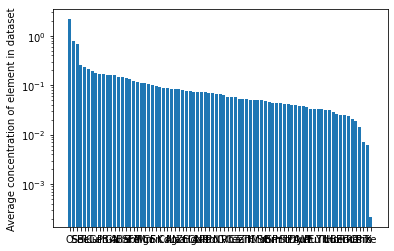

In [4]:
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    for e in s:
        elements[e] += s[e]
        proportions[e] += [s[e]]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w");
ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel("Average concentration of element in dataset");

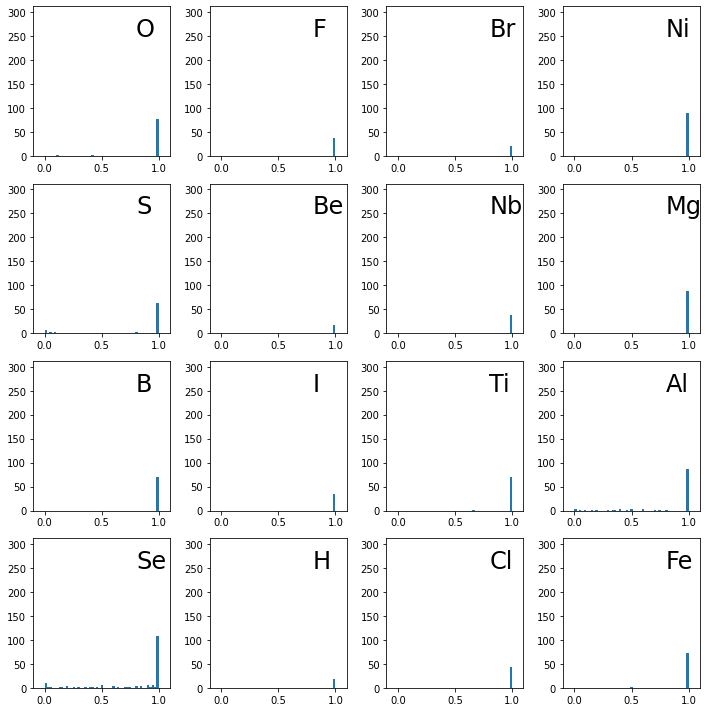

In [5]:
# distribution of element proportions across compositions
fig, ax = plt.subplots(4, 4, facecolor="w", figsize=(10, 10))
for axis, elem in zip(itertools.product(range(0, 4), repeat=2), mean_proportions):
    axis = (axis[1], axis[0])
    ax[axis].hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax[axis].set_xlim(-0.1, 1.1)
    ax[axis].text(0.75, 0.8, elem, fontsize=24, transform=ax[axis].transAxes, )
    ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [6]:
df.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


Text(0.5, 0, 'Band gap (eV)')

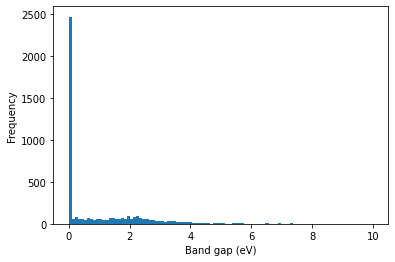

In [7]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["gap expt"], bins=np.asarray([0] + np.linspace(0.0, 10, 100).tolist()), density=False);
ax.set_ylabel("Frequency")
ax.set_xlabel("Band gap (eV)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [3]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [4]:
PRECOMPUTED_MODDATA = "./precomputed/expt_gap_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_expt_gap")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["gap expt"].tolist(), 
        target_names=["gap expt (eV)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATACOMPUTED_MODDATA)
    data.feature_selection(n=-1)
    data.save(PRECOMPUTED_MODDATACOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f8da85365e0> object, created with modnet version 0.1.8~develop


In [8]:
data.feature_selection(n=150)

INFO:root:Starting target 1/1: gap expt (eV) ...
INFO:root:Computing mutual information between features and target...
INFO:root:Computing optimal features...
INFO:root:Selected 50/150 features...
INFO:root:Selected 100/150 features...
INFO:root:Done with target 1/4604: gap expt (eV).
INFO:root:Merging all features...
INFO:root:Done.


In [11]:
data.save(PRECOMPUTED_MODDATAOMPUTED_MODDATA)

INFO:root:Data successfully saved as ./precomputed/expt_gap_benchmark_moddata.pkl.gz!


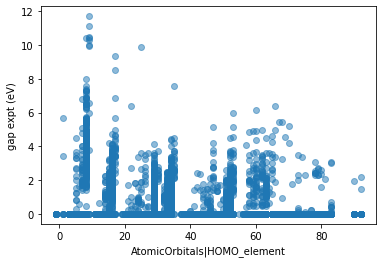

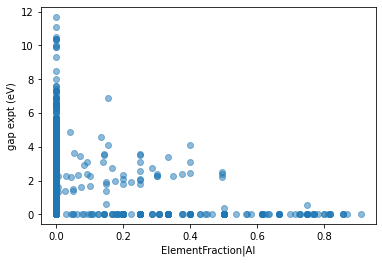

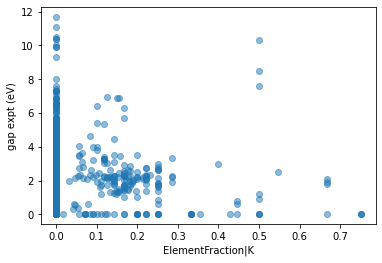

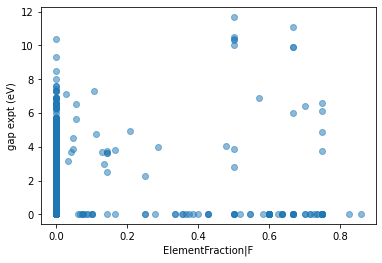

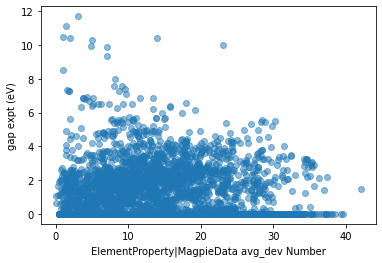

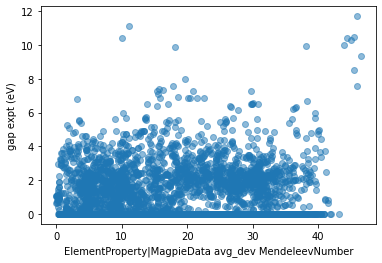

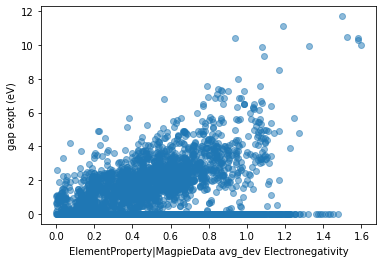

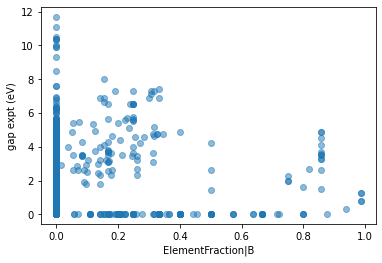

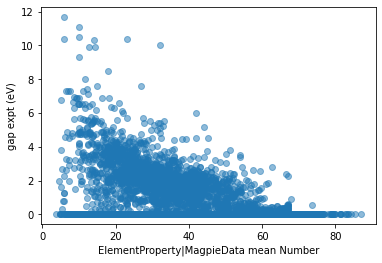

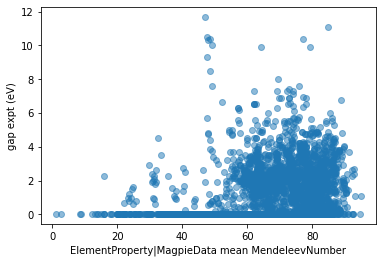

In [9]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel(data.target_names[0])

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [25]:
def benchmark(model, data):
    import seaborn as sns
    predictions = model.predict(data)
    errors = np.abs(predictions.values - data.df_targets.values)
    fig, ax = plt.subplots(facecolor="w")
    ax.hist(errors, bins=100)
    
    units = data.target_names[0].split()[-1].replace("(", "").replace(")", "")
    ax.set_ylabel("Frequency")
    ax.set_xlabel(f"Absolute error ({units})")
    ax.axvline(95.2, ls='--', color='k', label="Automatminer RF")
    ax.axvline(np.mean(model.history.history["val_mae"]), 0, 1, ls='--', color='r', label="Validation MAE")
    ax.axvline(np.mean(errors), ls='--', color='b', label="Test MAE")
    ax.legend()
    
    fig, ax = plt.subplots(facecolor="w")
    ax.scatter(data.df_targets.values, predictions.values, alpha=0.25)
    ax.plot(np.linspace(*plt.xlim(), 2), np.linspace(*plt.xlim(), 2))
    sns.regplot(x=data.df_targets.values, y=predictions.values, ax=ax)
    ax.set_xlabel(f"{data.target_names[0]} (true)")
    ax.set_ylabel(f"{data.target_names[0]} (pred)")
    ax.text(0.75, 0.5, 
            f"Test MAE: {np.mean(errors):3.1f} {units}", 
            transform=ax.transAxes,
    )
    
    fig, ax = plt.subplots(facecolor="w")
    ax.plot(model.history.history["val_mae"][10:])
    ax.axhline(95.2, ls='--', color="k", label="Automatminer RF")
    ax.set_ylim(np.mean(errors)*0.5, np.mean(errors)*1.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(f"Validation MAE ({units})")

In [10]:
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

MATBENCH_SEED = 18012019

kf = KFold(n_splits=5, shuffle=True, random_state=MATBENCH_SEED)
kf_splits = kf.split(data.df_featurized, y=data.df_targets)

verbose = False

callbacks = [
    ReduceLROnPlateau(monitor="loss", factor=0.5, patience=20, mode="auto", min_delta=0.0, verbose=verbose), 
    EarlyStopping(monitor="loss", min_delta=0.01, patience=300, mode="auto", baseline=None, restore_best_weights=True, verbose=verbose)
]

data.df_targets.rename(columns={data.target_names[0]: "E_g"}, inplace=True)

best_models = []

for train, test in kf_splits:
    
    train_moddata, test_moddata = data.split((train, test))
    
    model = MODNetModel(
        [[["E_g"]]], 
        {"E_g": 1}, 
        num_neurons=([32], [128], [8], []), 
        n_feat=32,
        act="elu",
    )
    model.fit(
        training_data=train_moddata, 
        batch_size=32, 
        epochs=10000, 
        val_data=test_moddata,
        loss="mae",
        lr=0.005,
        verbose=0,
        callbacks=callbacks
    )
    
    best_models.append(model)

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


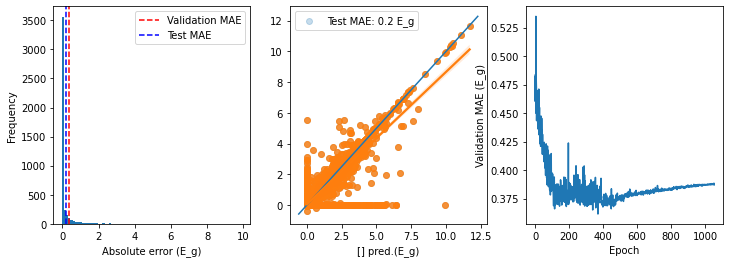

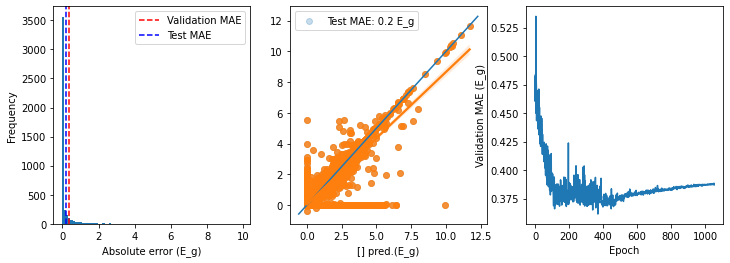

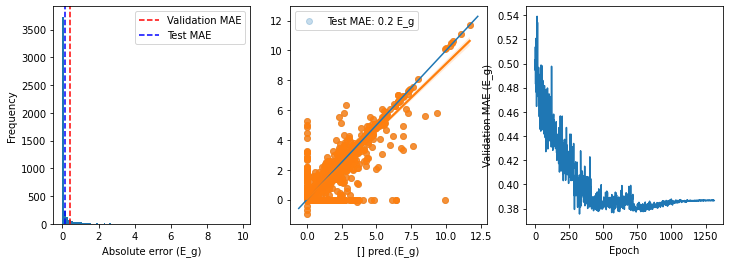

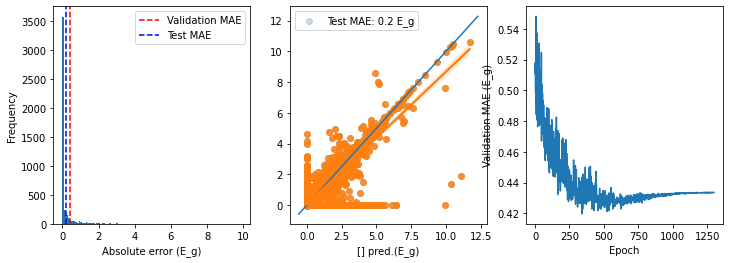

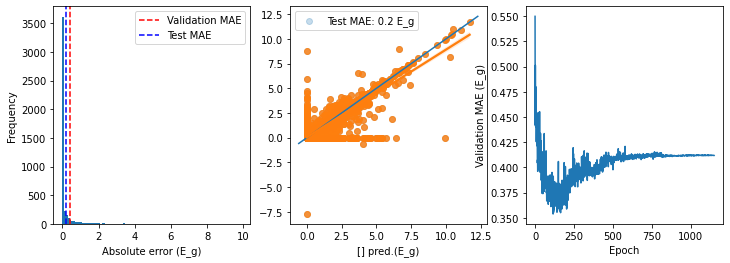

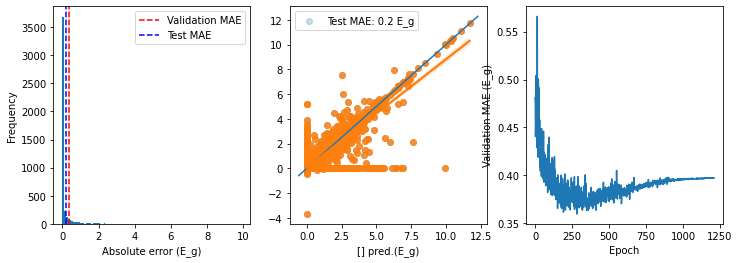

In [17]:
try:
    plot_benchmark(best_models[0], data)
except:
    os.chdir("..")
    from modnet_matbench.utils import plot_benchmark
    
for i in range(5):
    plot_benchmark(best_models[i], data)

In [23]:
bs = 64
lr = 0.01
archs = [
    (64, [[64], [8], [8], []]),
    (64, [[64], [32], [8], [8]]),
    (64, [[128], [64], [32], [8]]),
    (128, [[128], [64], [32], [8]]),
]

epochs = 5000
loss = "mse"
act = "elu"

presets = [dict(batch_size=bs, lr=lr, epochs=epochs, loss=loss, act=act, n_feat=a[0], num_neurons=a[1]) for a in archs]

In [24]:
model = MODNetModel(
    [[["E_g"]]], 
    {"E_g": 1}, 
)

model.fit_preset(data, presets, val_fraction=0.2)

INFO:root:Training preset #1/4
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.945
INFO:root:Training preset #2/4
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.794
INFO:root:Training preset #3/4
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.641
INFO:root:Training preset #4/4
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 0.616
INFO:root:Preset #4 resulted in lowest validation loss.
Fitting all data...


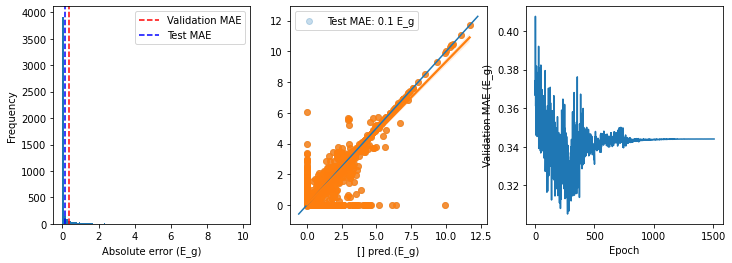

In [20]:
plot_benchmark(model, data)